# Locally Linear Embedding (40 P)

In this assignment we will look at locally linear embedding and experiment with it on artificially generated datasets. The effects of neighbourhood size and noise on result quality will be analyzed.

Information about the algorithm, publications and demos can be found at http://www.cs.nyu.edu/~roweis/lle/

A guide for plotting can be found here: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

We first start by importing some basic python libraries for numerical computation and plotting.

In [3]:
from __future__ import division

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy.spatial, scipy.linalg

The file `utils.py` contains several methods to generate pseudo-random three-dimensional datasets. They all have a low-dimensional manifold structure. The following code plots each dataset with default generation parameters (`N=1000` examples, and Gaussian noise of scale `0.25`).

spiral


C:\Users\huk\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


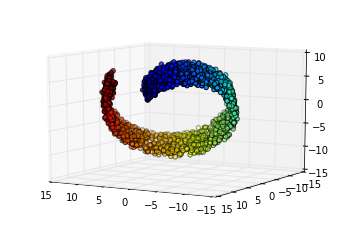

roll


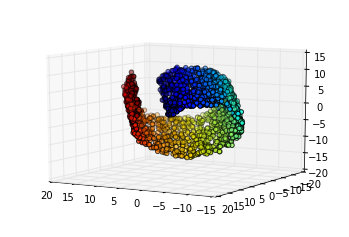

wave


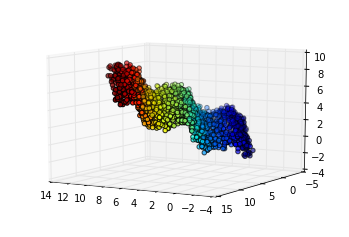

fold


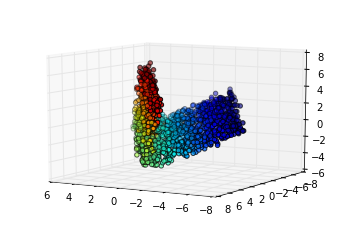

In [4]:
import utils
%matplotlib inline

for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    data,color = dataset(N=2000,noise=0.25)
    plt.figure()
    ax = plt.gca(projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    plt.show()

## Implementing LLE (20 P)

**Implement a function `LLE(data,k)`**. The function takes as input the high-dimensinonal data the number of neighbors `k` used for reconstruction in the LLE algorithm. It returns the resulting 2D embedding (a two-dimensional array of size `Nx2`). A backbone of the implementation is given below. The implementation of LLE is described in the paper "An Introduction to LLE" linked from ISIS.

*Reminder: During computation, you need to solve the problem Cw=**1**, where **1** is a column vector (1,1,...,1). In case k>d i.e. the size of the neighbourhood is larger than the number of dimensions of the space we're mapping to, it is necessary to regularize the matrix C. You can do this by adding positive terms on the diagonal. A good starting point is 0.05.*

In [50]:
# Backbone implementation
def LLE(data, k, d=2, delta=5e-4):
    N, D = data.shape
    W = np.zeros([N, N])  # matrix for storing reconstruction weights
    M = np.zeros([N, N])  # matrix M of which eigenvectors are computed
    E = np.zeros([N, 2])  # eigenvectors of M forming the embedding
    ones_vec = np.ones(D)
    data = data - np.mean(data, axis=0)
    
    kdtree = scipy.spatial.cKDTree(data, leafsize=k)
    # Iterate over all data points to find their associated reconstruction weights
    for i in range(N):
        # 1. find nearest neighbors of data[i]
        x_i = data[i]
        #    k+1 -> the query might return the x_i's index too,
        _, indexes = kdtree.query(x_i, k=(k+1), n_jobs=-1)
        #    so we remove it from the indexes if it's there,
        #    and then cap the lenth at k items
        indexes = indexes[indexes != i][:k]
        # 2. compute local covariance
        local_c = x_i - data[indexes]
        local_c = np.dot(local_c, local_c.T)
        #    (with diagonal regularization),
        local_c += delta * np.trace(local_c) * np.eye(k)
        #    and invert it
        local_c_inv = np.linalg.inv(local_c)
        # 3. compute reconstruction weights
        w_i = np.dot(local_c_inv, np.ones(k))
        #    and store them in the row of the matrix W
        W[i, indexes] = w_i/np.sum(w_i)
    # 4. Compute the matrix M from W
    M = np.eye(N) - W
    M = np.dot(M.T, M)
    #    and compute the desired eigenvectors E of M-
    eig_vals, E = np.linalg.eig(M)

    # Array of sums over each eigenvector
    sumflat_eig_vecs = E.sum(axis=0)**2
    
    # Remove the vector with equal components not summing up to zero, where
    # eigenvectors are still unit-vectors. So we find it by using this filter:
    mask = sumflat_eig_vecs < 1
    eig_vals = eig_vals[mask]
    E = E[:, mask]
    
    # Find indices of the smallest d eigenvectors (smallest wrt. eig_vals)
    sorted_idx = np.argsort(eig_vals)[:d]

    # Result: The smallest d eigenvectors
    return E[:, sorted_idx]

# LLE(np.array([[1,2,-3],[4,5,6],[7,-8,9],[-5,6,7],[5,6,9]]),2) 

**Test your implementation by running the code below.** It plots the original data (projected on the first two dimensions), and below, the two-dimensional embedding. A correct implementation produces a two-dimensional dataset where the manifold is unfolded, and where nearby points in the embedding are also neighbors in the manifold, in particular, neighboring points in the plot should have similar color.

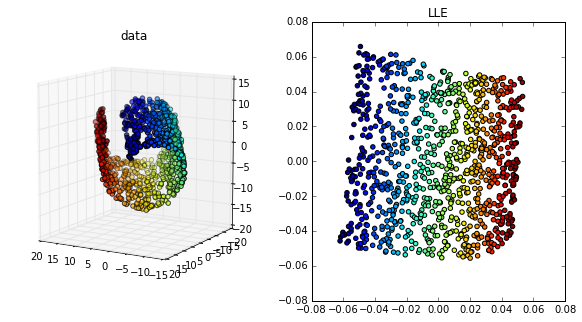

In [51]:
import utils
%matplotlib inline
data,color = utils.roll()
embedding = LLE(data,k=20) 
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.view_init(elev=10., azim=120)
ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
ax.set_title('data')

ax = fig.add_subplot(1,2,2)
ax.scatter(embedding[:,0], embedding[:,1], c=color)
ax.set_title('LLE');

## Experiments (20 P)

The function `compare(embed,dataset)`takes as input an embedding function and a dataset and plots the resulting embeddings for various choices of the parameter `k`, in particular, `k=5,20,80`.

In [45]:
def compare(embed, dataset):
    cols = 4
    
    fig = plt.figure(figsize=(3*cols, 3))
    
    # Plot the data
    data, color = dataset()
    ax = fig.add_subplot(1, cols, 1,projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    
    ax.set_title('data')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_zticks([], [])

    # Plot embeddings with various parameters K
    for i, k in enumerate([5,20,80]):
        ax = fig.add_subplot(1, cols, 2+i)

        z = embed(data,k=k)

        ax.scatter(z[:,0], z[:,1], c=color)
        ax.set_title('LLE, k=%d'%k)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
    plt.tight_layout()
    plt.show()

### Datasets and optimal parameter `k`

The code below tests the LLE embedding algorithm on each dataset: spiral, roll, wave, and fold. **Explain** what is a good parameter `k` of the LLE algorithm, and how this parameter relates to the various properties of the dataset.

**ANSWER:**

The parameter `k` affects the size of the space the algorithm considers as "local".

A too small value of `k` will cause LLE to missrepresent the structure in the original space, whereas a too large value of `k` has the risk of treating a neighbors points that are actually not.

Examples of the first problem can be seen below in all LLE runs with `k=5`. The projections of the different datasets fail to capture the local relationships.

On the other hand, the projections obtained by LLE with `k=80` on the `spiral` and `roll` datasets show how the blue and red points are mistakenly projected as if they were neighboring.

A good choice of `k` is then the smallest possible number that sufficiently captures the structure of the original data ("suficient" being problem-specific).

spiral


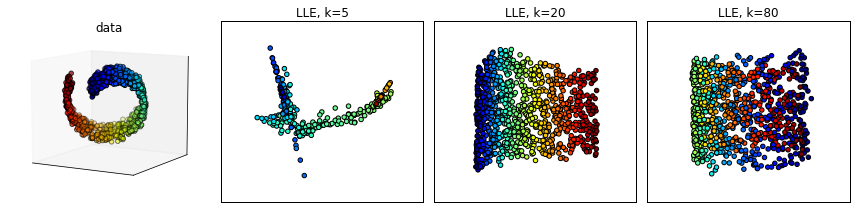

roll


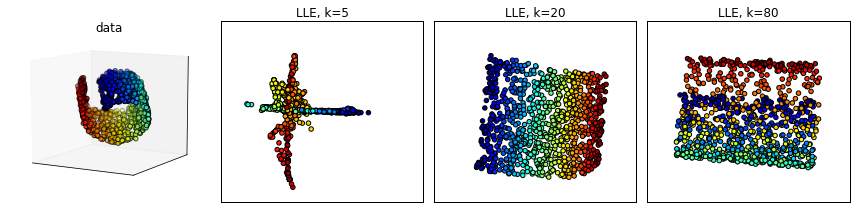

wave


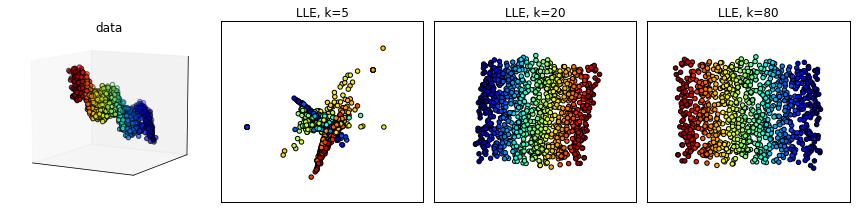

fold


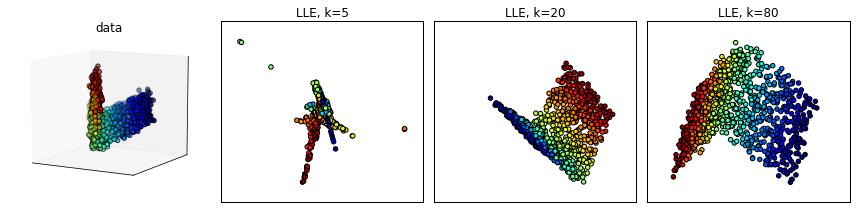

In [48]:
for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    compare(LLE,dataset)

### LLE and the effect of noise

The code below tests LLE on the spiral dataset with three different levels of noise. **Describe** how the noise affects the embedding.

**[TODO: WRITE YOUR ANSWER HERE]**

noise=0.100


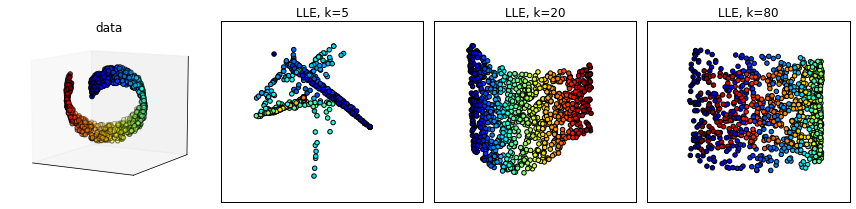

noise=0.300


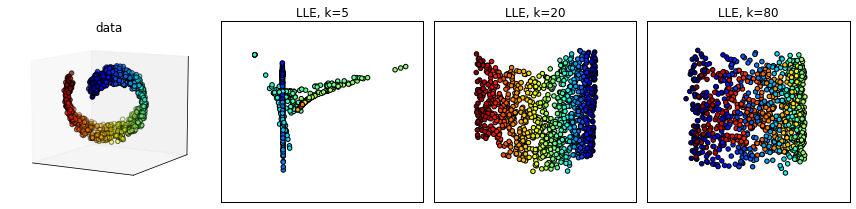

noise=1.000


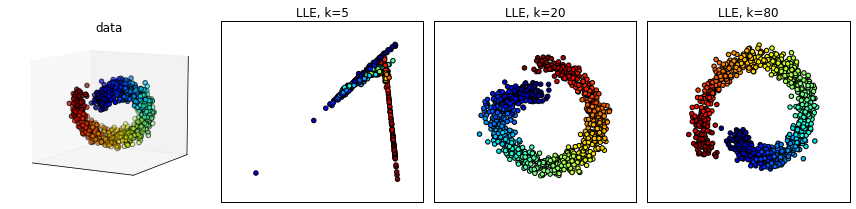

In [49]:
for noise in [0.1,0.3,1.0]:
    print('noise=%.3f'%noise)
    dataset = lambda: utils.spiral(noise=noise)
    compare(LLE,dataset)

### Discussion

* When applying LLE to a 200-dimensional dataset which can't be visualized, how would you assess whether the found embedding is good? Discuss how you would do it or argue why it can't be done.

**ANSWER:**

The easiest way would be to compare the embedding to other projection method(s).

Other way could be to draw 2D scatter plots of pairwise features. If there is some interesting structure in some of the scatter plots, and these are not represented in the embedding, then the embedding is not good enough.


* Could utilizing this technique in conjuction with a classifier improve its performance? Which classifiers, if any, would benefit the most?

**ANSWER:**

LLE used as a preprocessing step could improve the performance of linear classifiers, like kernel machines and logistic regression models.